# Project Setup

## Imports

In [1]:
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sklearn as sk
import pywt
import skl2onnx
import tensorflow as tf
import tensorflow_hub as hub
import time

start_time = time.time()
print(tf.__version__)

2025-06-07 09:21:09.084875: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 09:21:09.087669: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 09:21:09.095940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749313269.110796   34870 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749313269.115210   34870 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749313269.126777   34870 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

2.19.0


## Global Variables

In [2]:
RANDOM_SEED = 42
WINDOW_SIZE = 6616 # From 01_data_reformatting.ipynb
SAMPLE_RATE = 22050 # From 01_data_reformatting.ipynb

np.random.seed(RANDOM_SEED)

# Load Data

In [3]:
train_x = pd.read_csv(os.path.join("data", "train_test_split", "train_x.csv"), header=None).values
train_y = np.squeeze(pd.read_csv(os.path.join("data", "train_test_split", "train_y.csv"), header=None).values)
test_x = pd.read_csv(os.path.join("data", "train_test_split", "test_x.csv"), header=None).values
test_y = np.squeeze(pd.read_csv(os.path.join("data", "train_test_split", "test_y.csv"), header=None).values)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2916, 6616)
(2916,)
(1082, 6616)
(1082,)


# Feature Extraction
* Audio data are transformed into decible Mel spectograms (2D arrays) for some models

In [4]:
def transform_audio_to_spectrogram(audio_values: np.array, n_fft: int = 2048, top_db: float = 75.0) -> np.array:
    """Transform audio values into a magnitude spectrogram in decibels,
       ensuring the output has the same number of time frames as the input.
    """
    audio_stft = librosa.stft(
        y=audio_values,
        n_fft=n_fft,
    )
    audio_abs = np.abs(audio_stft)
    audio_db = librosa.amplitude_to_db(audio_abs, top_db=top_db)
    return np.array(audio_db)


def transform_audio_to_mel_spectrogram(audio_values: np.array, sr: int, n_mels: int = 128, top_db: float = 80.0) -> np.array:
    """Transform audio values into a Mel spectrogram in decibels.

    Args:
        audio_values: The audio waveform as a NumPy array.
        sr: The sampling rate of the audio.
        n_mels: The number of Mel bands to use.
        top_db: The maximum decibel value to use.

    Returns:
        The Mel spectrogram as a NumPy array.
    """
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_values, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel_spectrogram, top_db=top_db)
    return np.array(mel_db)


def center_on_max(audio_values: np.array, window_size: int = 6616) -> np.array:
    """Center the audio values on the maximum value within a specified window size."""
    # Find the index of the maximum absolute value
    max_index = np.argmax(np.abs(audio_values))
    
    # Calculate the center of the window
    center_idx = window_size // 2
    
    # Create output array of the specified window size
    centered_audio = np.zeros(window_size)
    
    # Calculate how much to shift (positive means shift right, negative means shift left)
    shift = center_idx - max_index
    
    if shift == 0:
        return audio_values
    elif shift > 0:
        # Maximum is to the left of center, need to shift right
        max_chunk_src_start= 0
        max_chunk_src_end = window_size - shift
        max_chunk_dst_start = shift
        max_chunk_dst_end = window_size
        # Other chunk will be pulled from the right end of the audio and put on the left end of the centered array
        other_chunk_src_start = window_size - shift
        other_chunk_src_end = window_size
        other_chunk_dst_start = 0
        other_chunk_dst_end = shift
    else:
        # Maximum is to the right of center, need to shift left
        max_chunk_src_start = -shift
        max_chunk_src_end = window_size
        max_chunk_dst_start = 0
        max_chunk_dst_end = window_size + shift
        # Other chunk will be pulled from the left end of the audio and put on the right end of the centered array
        other_chunk_src_start = 0
        other_chunk_src_end = -shift
        other_chunk_dst_start = window_size + shift
        other_chunk_dst_end = window_size
    
    # Copy values from source to destination array
    centered_audio[max_chunk_dst_start:max_chunk_dst_end] = audio_values[max_chunk_src_start:max_chunk_src_end]
    centered_audio[other_chunk_dst_start:other_chunk_dst_end] = audio_values[other_chunk_src_start:other_chunk_src_end]

    return centered_audio


def center_all_on_max(audio_values: np.array, window_size: int = 6616) -> np.array:
    """Center all audio values on the maximum value within a specified window size."""
    centered_audio = np.zeros((audio_values.shape[0], window_size))
    for i, audio in enumerate(audio_values):
        centered_audio[i] = center_on_max(audio, window_size)
    return centered_audio

def extract_max_abs(audio_values: np.array) -> np.array:
    """Extract the maximum value from each audio sample."""
    max_values = np.zeros((audio_values.shape[0], 2))
    for i, audio in enumerate(audio_values):
        max_values[i] = np.array([1, np.max(np.abs(audio))])
    return max_values

In [5]:
train_x_spectrogram = transform_audio_to_spectrogram(train_x, n_fft=WINDOW_SIZE)
test_x_spectrogram = transform_audio_to_spectrogram(test_x, n_fft=WINDOW_SIZE)

train_x_mel_spectrogram = transform_audio_to_mel_spectrogram(train_x, sr=SAMPLE_RATE, n_mels=256)
test_x_mel_spectrogram = transform_audio_to_mel_spectrogram(test_x, sr=SAMPLE_RATE, n_mels=256)

train_x_centered = center_all_on_max(train_x, window_size=WINDOW_SIZE)
test_x_centered = center_all_on_max(test_x, window_size=WINDOW_SIZE)

train_x_max_abs = extract_max_abs(train_x)
test_x_max_abs = extract_max_abs(test_x)

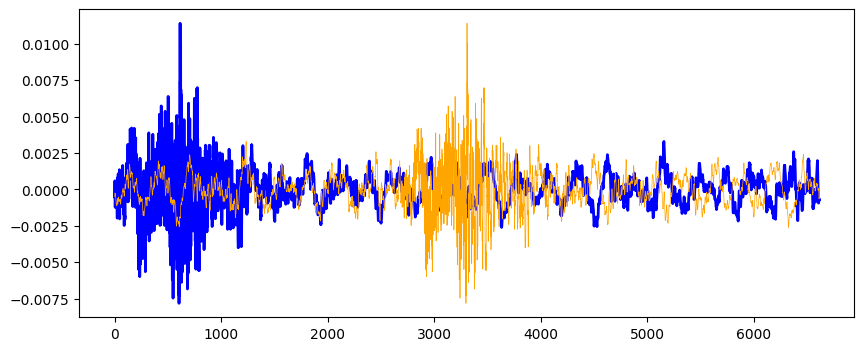

In [6]:
# Check centering on max works correctly by plotting an example audio sample
i = 5
plt.figure(figsize=(10, 4))
plt.plot(train_x[i], label="Original Audio", lw=2, color='blue')
plt.plot(train_x_centered[i], label="Centered Audio", color='orange', lw=0.5)
plt.show()

# Train Models

In [7]:
def evaluate_model(model, test_x: np.array, test_y: np.array):
    """
    Evaluate the model on the test data.
    """
    y_pred = list()
    prev = 0
    for i in range(test_y.shape[0]):
        if prev == 1:
            y_pred.append(np.array([0.0]))
            prev = 0
        else:
            prediction = model.predict_proba(np.expand_dims(test_x[i], axis=0))[:, 1]
            y_pred.append(prediction)
            prev = round(prediction[0])
    y_pred = np.array(y_pred)
    accuracy = sk.metrics.accuracy_score(
        test_y,
        np.round(y_pred),
    )
    auc = sk.metrics.roc_auc_score(
        test_y,
        y_pred,
    )
    fpr, tpr, _ = sk.metrics.roc_curve(
        test_y,
        y_pred,
    )
    return accuracy, auc, fpr, tpr


models = dict()

## Support Vector Machine

In [8]:
models["SVM"] = dict()
models["SVM"]["model"] = sk.svm.SVC(probability=True, random_state=RANDOM_SEED)
models["SVM"]["model"].fit(train_x, train_y)
models["SVM"]["accuracy"], models["SVM"]["auc"], models["SVM"]["fpr"], models["SVM"]["tpr"] = evaluate_model(
    model=models["SVM"]["model"],
    test_x=test_x,
    test_y=test_y,
)

## SVM on Centered Data

In [9]:
models["SVM_cent"] = dict()
models["SVM_cent"]["model"] = sk.svm.SVC(probability=True, random_state=RANDOM_SEED)
models["SVM_cent"]["model"].fit(train_x_centered, train_y)
models["SVM_cent"]["accuracy"], models["SVM_cent"]["auc"], models["SVM_cent"]["fpr"], models["SVM_cent"]["tpr"] = evaluate_model(
    model=models["SVM_cent"]["model"],
    test_x=test_x_centered,
    test_y=test_y,
)

## Logistic Regression on Centered Data

In [10]:
models["log_cent"] = dict()
models["log_cent"]["model"] = sk.linear_model.LogisticRegression(
    penalty='l2',
    C=1.0,
    random_state=RANDOM_SEED,
    solver='lbfgs',
    max_iter=1000,
)
models["log_cent"]["model"].fit(train_x_centered, train_y)
models["log_cent"]["accuracy"], models["log_cent"]["auc"], models["log_cent"]["fpr"], models["log_cent"]["tpr"] = evaluate_model(
    model=models["log_cent"]["model"],
    test_x=test_x_centered,
    test_y=test_y,
)

## Log on Max Absolute Value

In [11]:
models["log_max_abs"] = dict()
models["log_max_abs"]["model"] = sk.linear_model.LogisticRegression(
    penalty='l2',
    C=1.0,
    random_state=RANDOM_SEED,
    solver='lbfgs',
    max_iter=1000,
)
models["log_max_abs"]["model"].fit(train_x_max_abs, train_y)
models["log_max_abs"]["accuracy"], models["log_max_abs"]["auc"], models["log_max_abs"]["fpr"], models["log_max_abs"]["tpr"] = evaluate_model(
    model=models["log_max_abs"]["model"],
    test_x=test_x_max_abs,
    test_y=test_y,
)

## CNN

In [12]:
class CNNClassifier(sk.base.BaseEstimator, sk.base.ClassifierMixin):
    """
    A scikit-learn compatible CNN classifier for binary classification.
    """
    def __init__(self, input_shape, epochs=10, batch_size=32, optimizer='adam',
                 loss='binary_crossentropy', metrics=['accuracy'], **kwargs):
        self.input_shape = input_shape
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.model_ = None  # Initialize the model as None
        self.kwargs = kwargs

    def _create_cnn_model(self):
        """
        Creates the CNN model.
        """
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(self.input_shape[0], self.input_shape[1], 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification, so sigmoid output
        ])
        return model

    def fit(self, X, y, **fit_params):
        """
        Fits the CNN models[i]s[i]s[i] to the training data.

        Args:
            X (numpy.ndarray): Training data of shape (n_samples, height, width).
            y (numpy.ndarray): Training labels of shape (n_samples,).
            **fit_params: Additional parameters passed to the model.fit method.

        Returns:
            self: Returns an instance of self.
        """
        # Reshape input data to have the channel dimension
        X_reshaped = np.expand_dims(X, axis=-1)

        self.model_ = self._create_cnn_model()
        self.model_.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
        self.model_.fit(X_reshaped, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0, **fit_params)  # Set verbose=0 for cleaner output
        return self

    def predict_proba(self, X):
        """
        Predicts the probability of each class for the given data.

        Args:
            X (numpy.ndarray): Input data of shape (n_samples, height, width).

        Returns:
            numpy.ndarray: Probabilities for each class (shape: (n_samples, 2)).
                           The first column is the probability of class 0, and the
                           second column is the probability of class 1.
        """
        sk.utils.validation.check_is_fitted(self)
        X_reshaped = np.expand_dims(X, axis=-1)
        probabilities_class_1 = self.model_.predict(X_reshaped)
        probabilities_class_0 = 1 - probabilities_class_1
        return np.hstack((probabilities_class_0, probabilities_class_1))

    def predict(self, X):
        """
        Predicts the class labels for the given data.

        Args:
            X (numpy.ndarray): Input data of shape (n_samples, height, width).

        Returns:
            numpy.ndarray: Predicted class labels (0 or 1).
        """
        probabilities = self.predict_proba(X)
        return (probabilities > 0.5).astype(int).flatten()

In [13]:
models["CNN"] = dict()
models["CNN"]["model"] = CNNClassifier(
    input_shape=(256, 13),
    epochs=10,
    batch_size=32,
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)
models["CNN"]["model"].fit(
    train_x_mel_spectrogram,
    train_y,
)
models["CNN"]["accuracy"], models["CNN"]["auc"], models["CNN"]["fpr"], models["CNN"]["tpr"] = evaluate_model(
    model=models["CNN"]["model"],
    test_x=test_x_mel_spectrogram,
    test_y=test_y,
)

/home/colin/code/bat_jester_model_training/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-07 09:25:34.791580: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

## YAMNet

In [14]:
class YAMNetBinary(tf.keras.Model):
    def __init__(self, yamnet_model):
        super(YAMNetBinary, self).__init__()
        self.yamnet = yamnet_model
        self.dense = tf.keras.layers.Dense(128, activation="relu")
        self.binary_output = tf.keras.layers.Dense(1, activation="sigmoid")

    def process_waveform(self, waveform):
        """Process a single waveform and return the embedding."""
        sample_length = tf.shape(waveform)[0]

        # Use tf.cond for conditional logic instead of Python if/else
        def truncate_fn():
            return waveform[:15600]

        def pad_fn():
            padding = tf.zeros(15600 - sample_length, dtype=tf.float32)
            return tf.concat([waveform, padding], axis=0)

        # Use tf.cond for TensorFlow-compatible conditional
        processed_waveform = tf.cond(sample_length >= 15600, truncate_fn, pad_fn)

        # Run YAMNet on this individual sample
        scores, embeddings, spectrogram = self.yamnet(processed_waveform)

        # Take the mean embedding across all frames
        mean_embedding = tf.reduce_mean(embeddings, axis=0)
        return mean_embedding

    def call(self, inputs):
        # Use tf.map_fn to process each sample in the batch
        batch_embeddings = tf.map_fn(
            self.process_waveform, inputs, fn_output_signature=tf.float32
        )

        # Binary classification layers
        x = self.dense(batch_embeddings)
        binary_predictions = self.binary_output(x)

        return binary_predictions
    
    def predict_proba(self, X):
        """
        Returns probability estimates for samples in X.
        
        Args:
            X: Input samples
            
        Returns:
            Array of shape (n_samples, 2) where each row contains 
            [1-p, p] for the probability p of the positive class
        """
        probs = self.predict(X).flatten()
        # Return probabilities for both classes (required format for sklearn metrics)
        return np.vstack((1-probs, probs)).T



def create_yamnet_binary_classifier():
    """
    Creates a model that uses YAMNet as a feature extractor and adds a binary classification layer.
    """
    # Load YAMNet from TensorFlow Hub
    yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")
    model = YAMNetBinary(yamnet_model)
    return model

In [15]:
models["YAMNet"] = dict()
models["YAMNet"]["model"] = create_yamnet_binary_classifier()
models["YAMNet"]["model"].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
models["YAMNet"]["model"].fit(
    train_x,
    train_y,
    epochs=10,
)
models["YAMNet"]["accuracy"], models["YAMNet"]["auc"], models["YAMNet"]["fpr"], models["YAMNet"]["tpr"] = evaluate_model(
    model=models["YAMNet"]["model"],
    test_x=test_x,
    test_y=test_y,
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5670 - loss: 0.6955
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6292 - loss: 0.6433
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6486 - loss: 0.6253
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.6582 - loss: 0.6101
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.6697 - loss: 0.5993
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6736 - loss: 0.5906
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.6930 - loss: 0.5681
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6941 - loss: 0.5628
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7101 - loss: 0.5560
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7363 - loss: 0.5346
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/

## Wavelet + RandomForest

In [16]:
class WaveletClassifier:
    def __init__(
        self, wavelet="db4", level=4, test_size=0.2, random_state=42, n_estimators=100
    ):
        """
        Initialize the wavelet classifier.

        Parameters:
        -----------
        wavelet : str, default="db4"
            The wavelet to use for feature extraction
        level : int, default=4
            The level of wavelet decomposition
        test_size : float, default=0.2
            The proportion of the dataset to include in the test split
        random_state : int, default=42
            Controls the randomness of the classifier
        n_estimators : int, default=100
            The number of trees in the forest
        """
        self.wavelet = wavelet
        self.level = level
        self.test_size = test_size
        self.random_state = random_state
        self.n_estimators = n_estimators
        self.clf = None
        self.scaler = None

    def _wavelet_feature_extraction(self, audio_data):
        """Extracts wavelet features from audio data."""
        coeffs = pywt.wavedec(audio_data, self.wavelet, level=self.level)
        features = np.concatenate(
            [np.atleast_1d(np.mean(np.abs(c), axis=0)) for c in coeffs]
        )
        return features

    def fit(self, X_train, y_train):
        """
        Train the classifier on the input data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The training audio data
        y : array-like of shape (n_samples,)
            The target labels

        Returns:
        --------
        self : object
            Returns self
        """
        features = np.array([self._wavelet_feature_extraction(audio) for audio in X_train])
        # Standardize features
        self.scaler = sk.preprocessing.StandardScaler()
        features = self.scaler.fit_transform(features)
        # Train a classifier (Random Forest in this example)
        self.clf = sk.ensemble.RandomForestClassifier(
            n_estimators=self.n_estimators, random_state=self.random_state
        )
        self.clf.fit(features, y_train)
        return self

    def predict(self, X):
        """
        Predict labels for the input data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input audio data

        Returns:
        --------
        y : array-like of shape (n_samples,)
            The predicted labels
        """
        if self.clf is None:
            raise ValueError("Classifier not fitted. Call fit first.")

        if isinstance(X, list) or (
            isinstance(X, np.ndarray) and len(X.shape) > 1 and X.ndim > 1
        ):
            # Multiple samples
            predictions = []
            for audio in X:
                feature = self._wavelet_feature_extraction(audio).reshape(1, -1)
                feature = self.scaler.transform(feature)
                predictions.append(self.clf.predict(feature)[0])
            return np.array(predictions)
        else:
            # Single sample
            feature = self._wavelet_feature_extraction(X).reshape(1, -1)
            feature = self.scaler.transform(feature)
            return self.clf.predict(feature)[0]

    def predict_proba(self, X):
        """
        Predict label probabilities for the input data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input audio data

        Returns:
        --------
        y : array-like of shape (n_samples, 2)
            The predicted labels
        """
        if self.clf is None:
            raise ValueError("Classifier not fitted. Call fit first.")

        if isinstance(X, list) or (
            isinstance(X, np.ndarray) and len(X.shape) > 1 and X.ndim > 1
        ):
            # Multiple samples
            predictions = []
            for audio in X:
                feature = self._wavelet_feature_extraction(audio).reshape(1, -1)
                feature = self.scaler.transform(feature)
                predictions.append(self.clf.predict_proba(feature)[0])
            return np.array(predictions)
        else:
            # Single sample
            feature = self._wavelet_feature_extraction(X).reshape(1, -1)
            feature = self.scaler.transform(feature)
            return self.clf.predict_proba(feature)[0]

In [17]:
models["Wavelet"] = dict()
models["Wavelet"]["model"] = WaveletClassifier(wavelet="db4", level=4)
models["Wavelet"]["model"].fit(
    train_x,
    train_y,
)
models["Wavelet"]["accuracy"], models["Wavelet"]["auc"], models["Wavelet"]["fpr"], models["Wavelet"]["tpr"] = evaluate_model(
    model=models["Wavelet"]["model"],
    test_x=test_x,
    test_y=test_y,
)

## SVM on Spectrogram

In [18]:
models["SVM_Spec"] = dict()
models["SVM_Spec"]["model"] = sk.svm.SVC(probability=True, random_state=RANDOM_SEED)
models["SVM_Spec"]["model"].fit(
    train_x_spectrogram.reshape(
        train_x_spectrogram.shape[0], -1
    ),
    train_y,
)
models["SVM_Spec"]["accuracy"], models["SVM_Spec"]["auc"], models["SVM_Spec"]["fpr"], models["SVM_Spec"]["tpr"] = evaluate_model(
    model=models["SVM_Spec"]["model"],
    test_x=test_x_spectrogram.reshape(
        test_x_spectrogram.shape[0], -1
    ),
    test_y=test_y,
)

# Display Model Evaluation

SVM
Accuracy: 0.6404805914972274
AUC: 0.529519035463329

SVM_cent
Accuracy: 0.6432532347504621
AUC: 0.525261102876592

log_cent
Accuracy: 0.6118299445471349
AUC: 0.5018973704435661

log_max_abs
Accuracy: 0.6192236598890942
AUC: 0.5606609574000879

CNN
Accuracy: 0.544362292051756
AUC: 0.5225694444444444

YAMNet
Accuracy: 0.5637707948243993
AUC: 0.5048978233421169

Wavelet
Accuracy: 0.5517560073937153
AUC: 0.5256093544137023

SVM_Spec
Accuracy: 0.5831792975970426
AUC: 0.4879570158102766



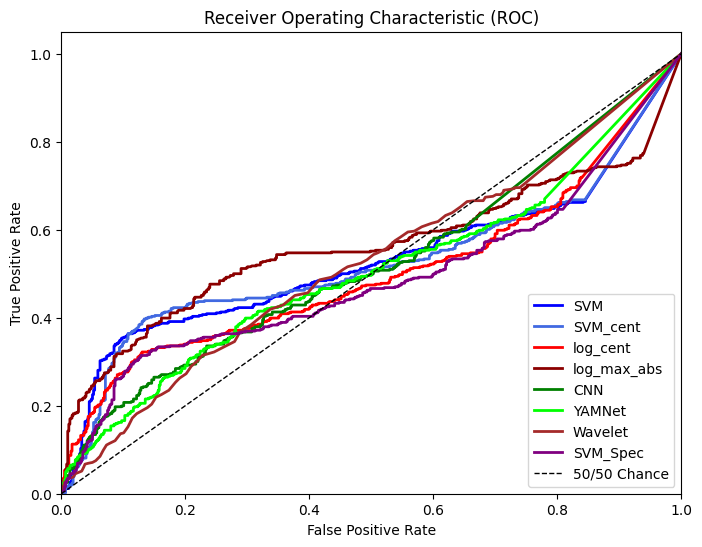

In [21]:
plt.figure(figsize=(8, 6))
colors = ['blue', 'royalblue', 'red', 'darkred', 'green', 'lime', 'brown', 'purple']
model_names = list(models.keys())
for i in range(len(model_names)):
    model = model_names[i]
    plt.plot(
        models[model]["fpr"],
        models[model]["tpr"], 
        color=colors[i],
        lw=2,
        label=model,
    )
    print(f"{model}\nAccuracy: {models[model]['accuracy']}\nAUC: {models[model]['auc']}\n")
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', label="50/50 Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Save Models for Deployment

In [22]:
# # Convert the model to ONNX
# onnx_model = skl2onnx.convert_sklearn(
#     models["SVM"]["model"], 
#     initial_types=[('float_input', skl2onnx.common.data_types.FloatTensorType([None, train_x[0].shape[0]]))]
# )
# # Save the ONNX model
# with open(os.path.join("data", "trained_models", f'model_svm_{pd.Timestamp.now()}.onnx'), 'wb') as f:
#     f.write(onnx_model.SerializeToString())

In [23]:
time.time() - start_time

1094.4132158756256